# Cloud Detection in Landsat 8 Images

In this notebook we will use a UNET CNN architecture to detect cloud and cloud shadows in Landsat 8 Imagery

In [2]:
import os
from pathlib import Path
import rasterio
import xrspatial.multispectral as ms
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window
from PIL import Image
import h5py
from tensorflow import keras
import tensorflow as tf 

from cloud_detection.models.unet import UNet
from cloud_detection.data.generator import DataGenerator
from cloud_detection.config import data_root, sample_root, target_root, IMG_SIZE, BATCH_SIZE, custom_cmap, custom_norm, custom_cmap_simple, custom_norm_simple, NUM_CLASSES, EPOCHS, standard_image
from cloud_detection.utils import get_l8_color, get_mask_array
from cloud_detection.data.scene import Scene, Mask
from sklearn.model_selection import train_test_split

data_files = sorted(list(data_root.glob('*_data.tif')))
quality_files = sorted(list(data_root.glob('*_qmask.tif')))
mask_files = sorted(list(data_root.glob('*_mask.png')))

import warnings
import rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

%load_ext autoreload
%autoreload 2

Num GPUs Available:  1


In [3]:
ds = xr.open_dataset(standard_image)
ds

<xarray.Dataset>
Dimensions:      (band: 10, x: 1000, y: 1000)
Coordinates:
  * band         (band) int32 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 2.4e+05 2.4e+05 2.401e+05 ... 2.7e+05 2.7e+05
  * y            (y) float64 -3.36e+06 -3.36e+06 ... -3.39e+06 -3.39e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

# Examine some of the samples and their labels

data\LC80010812013365LGN00_18_data.tif
data\LC80020622013244LGN00_32_data.tif
data\LC80050152014172LGN00_12_data.tif


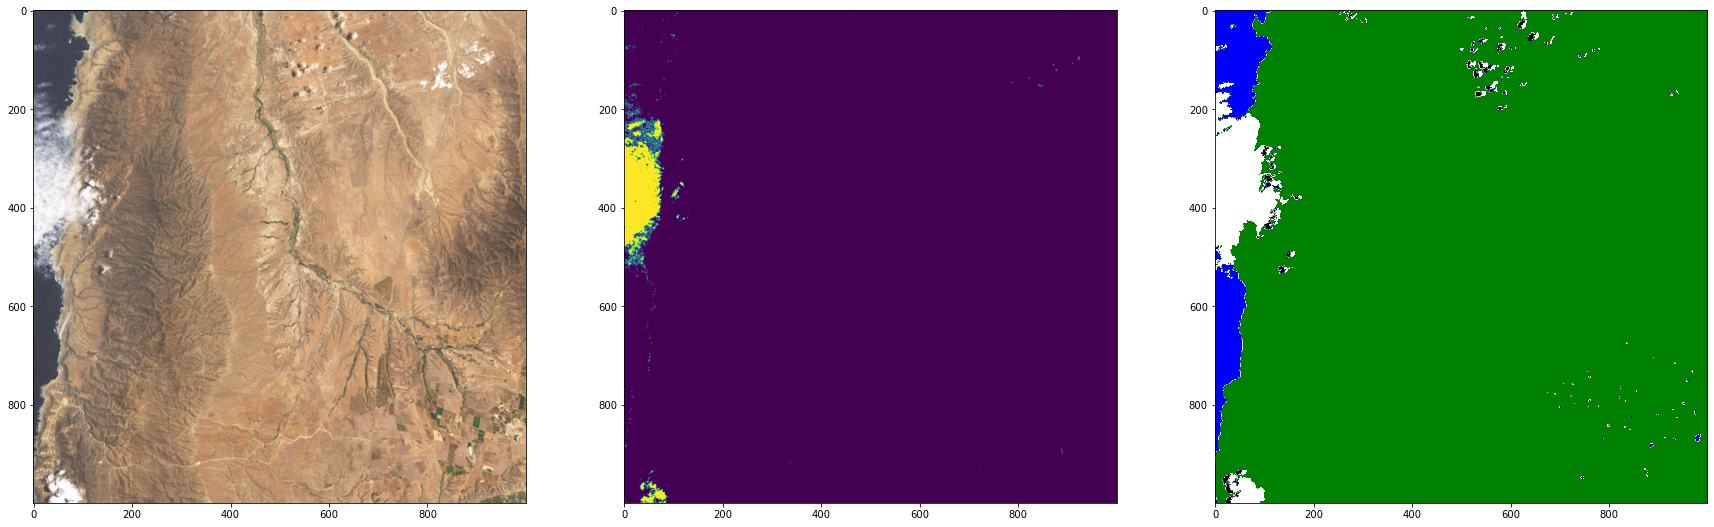

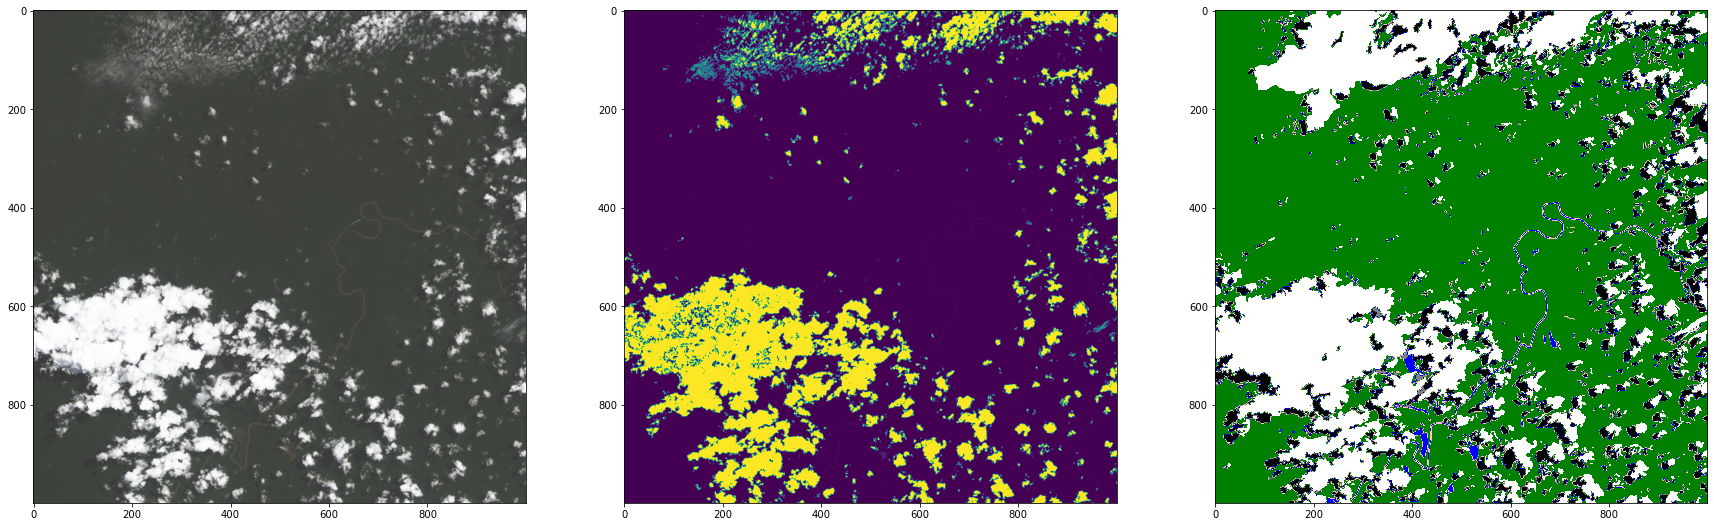

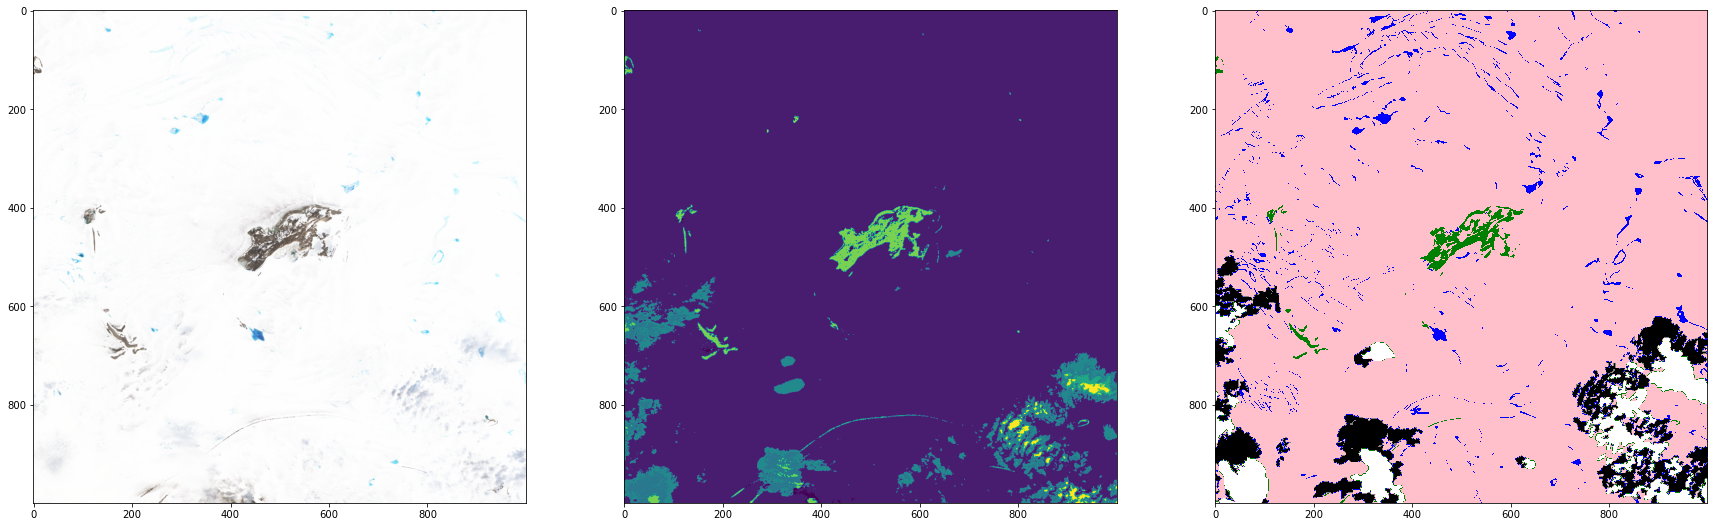

In [4]:
n_files = 3

for data_file, quality_file, mask_file in zip(data_files[:n_files], quality_files[:n_files], mask_files[:n_files]):
    print(data_file)
    color = get_l8_color(data_file)
    mask = get_mask_array(mask_file)
   
    quality = xr.open_dataset(quality_file)
    quality_plot = quality.sel({'band': 1}).band_data

    fig, ax = plt.subplots(1,3,figsize=(30, 10))
    ax[0].imshow(color.values)
    ax[1].imshow(quality_plot.values)
    ax[2].imshow(mask, cmap=custom_cmap, norm=custom_norm)

# Prepare samples
Here we cut the samples into chips to more easily fit into memory
REMEMBER: I NEED TO GET THE REST OF THE IMAGE USING PADDING

In [5]:
kernel_x, kernel_y = IMG_SIZE

for data_file, mask_file in zip(data_files, mask_files):
    scene = Scene(data_file)
    mask = rasterio.open(mask_file)
    x_dim, y_dim = scene.geodata.band_data.sel({'band': 2}).shape
    
    chip = 0
    for x1, x2 in zip(np.arange(0, x_dim, kernel_x), np.arange(kernel_x, x_dim, kernel_x)):
        for y1, y2 in zip(np.arange(0, y_dim, kernel_y), np.arange(kernel_y, y_dim, kernel_y)):
            data_chip = scene.geodata.isel(x=slice(x1, x2), y=slice(y1,y2))
            data_chip.band_data.rio.to_raster(os.path.join(str(sample_root.absolute()), data_file.stem + f'_{chip}.tif'))
                     
            window = Window.from_slices((y1, y2), (x1, x2))
            mask_data = mask.read(1, window=window)
           
            im = Image.fromarray(mask_data)
            im.save(os.path.join(str(target_root.absolute()), data_file.stem + f'_{chip}.tif'))

            chip += 1

# Verify chips

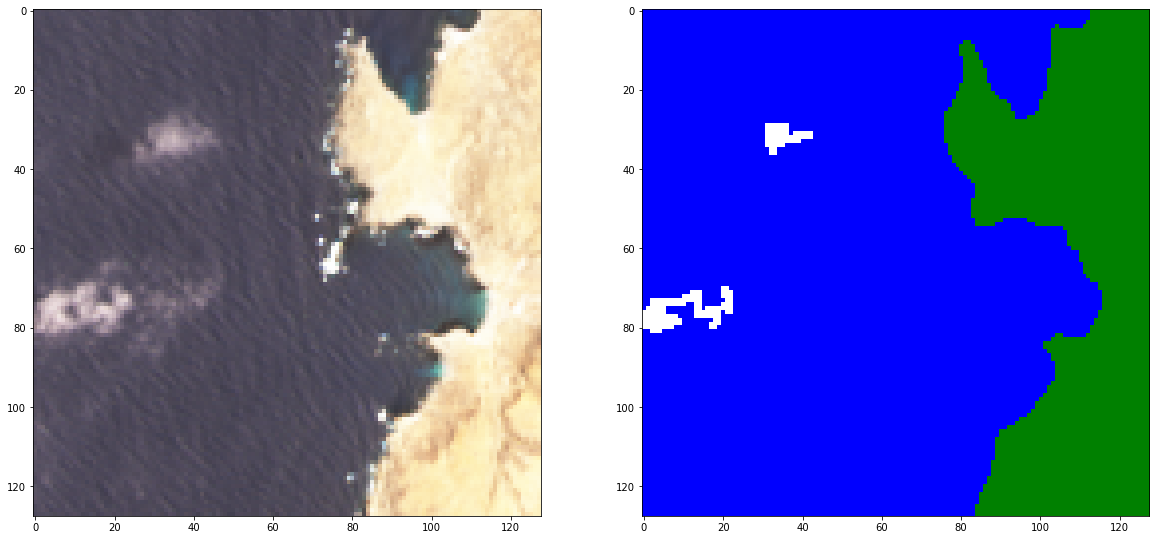

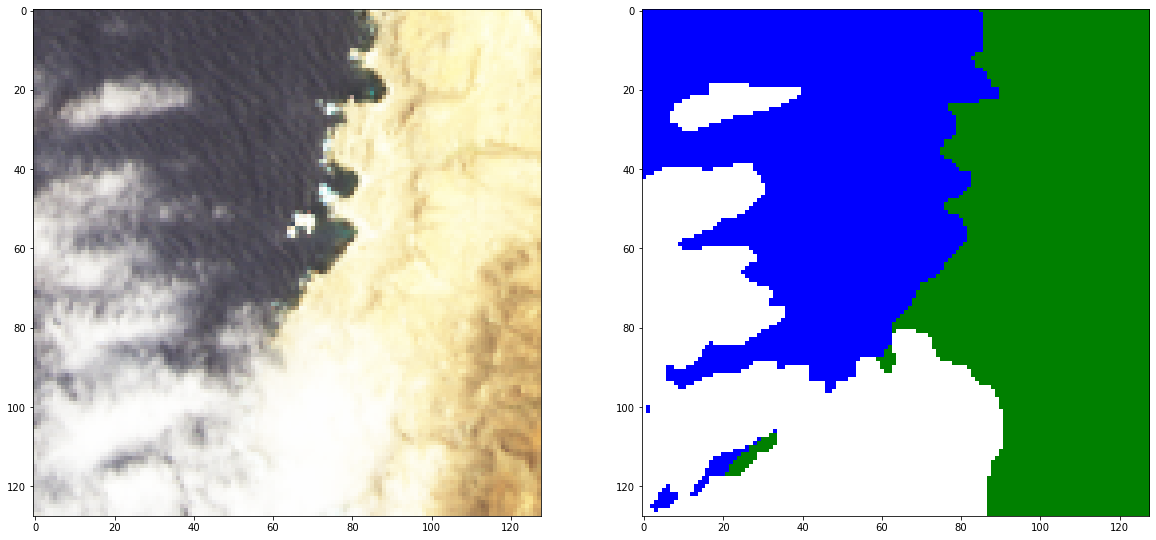

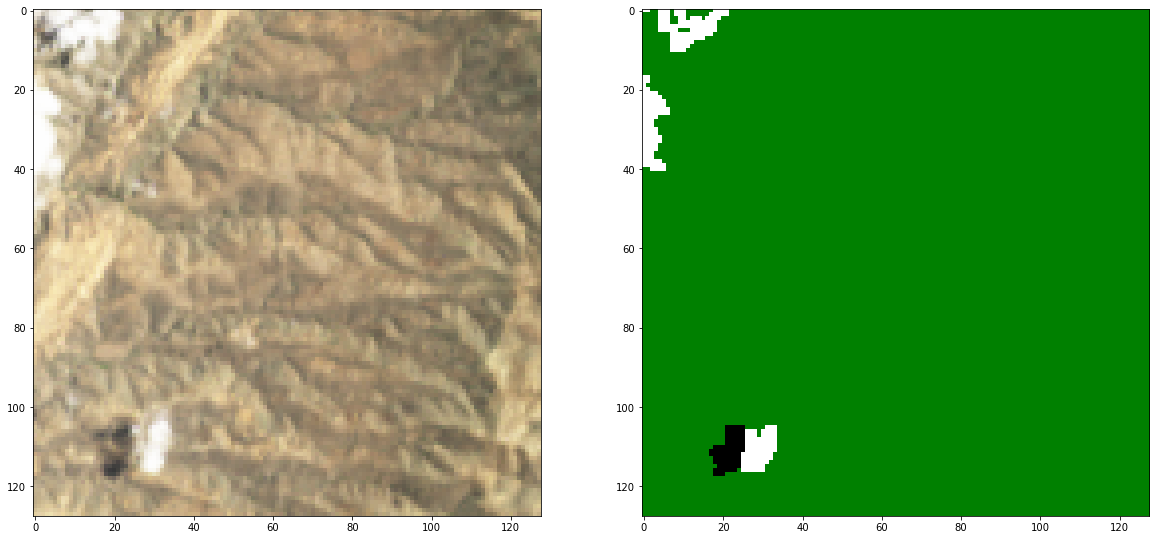

In [6]:
data_files = sorted(list(sample_root.glob('*.tif')))
mask_files = sorted(list(target_root.glob('*.tif')))

n_files = 3

for data_file, mask_file in zip(data_files[:n_files], mask_files[:n_files]):
    color = get_l8_color(data_file)
    mask = get_mask_array(mask_file)

    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[0].imshow(color.values[:,:,0:3])
    ax[1].imshow(mask, cmap=custom_cmap, norm=custom_norm)

# Create a data generator

In [7]:
seed = 1334
sample_files = sorted(list(sample_root.glob('*.tif')))
target_files = sorted(list(target_root.glob('*.tif')))

sample_files = [str(file.absolute()) for file in sample_files]
target_files = [str(file.absolute()) for file in target_files]

X_train, X_test, y_train, y_test = train_test_split(sample_files, target_files, test_size=0.2, random_state=seed)

train_generator = DataGenerator(BATCH_SIZE, IMG_SIZE, X_train, y_train)
test_generator = DataGenerator(BATCH_SIZE, IMG_SIZE, X_test, y_test)

# Create model and run

In [30]:
input_shape = (list(IMG_SIZE) + [10])

model = UNet(input_shape)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
loss=tf.keras.losses.CategoricalCrossentropy(),
metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES), 
tf.keras.metrics.OneHotIoU(7, [0,1,2,3,4,5,6]),
tf.keras.metrics.CategoricalAccuracy()])

callbacks = [keras.callbacks.ModelCheckpoint("checkpoint.h5", save_best_only=True),
            
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.01,
                patience=10,
                verbose=0,
                mode='auto',
                baseline=None,
                restore_best_weights=True
            )
            
]

EPOCHS=50
history = model.fit(train_generator, epochs=EPOCHS, validation_data=test_generator, callbacks=callbacks)

Epoch 1/50
196/196 [==============================] - ETA: 0s - loss: 0.6416 - one_hot_mean_io_u_3: 0.4090 - one_hot_io_u_3: 0.4090 - categorical_accuracy: 0.8142

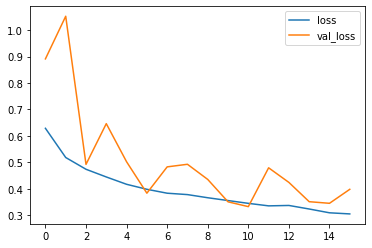

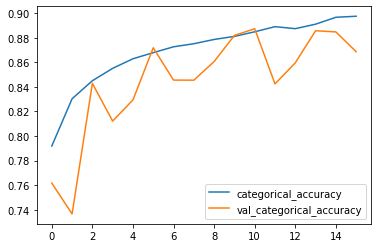

In [26]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.figure()
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()

In [9]:
val_preds = model.predict(test_generator)

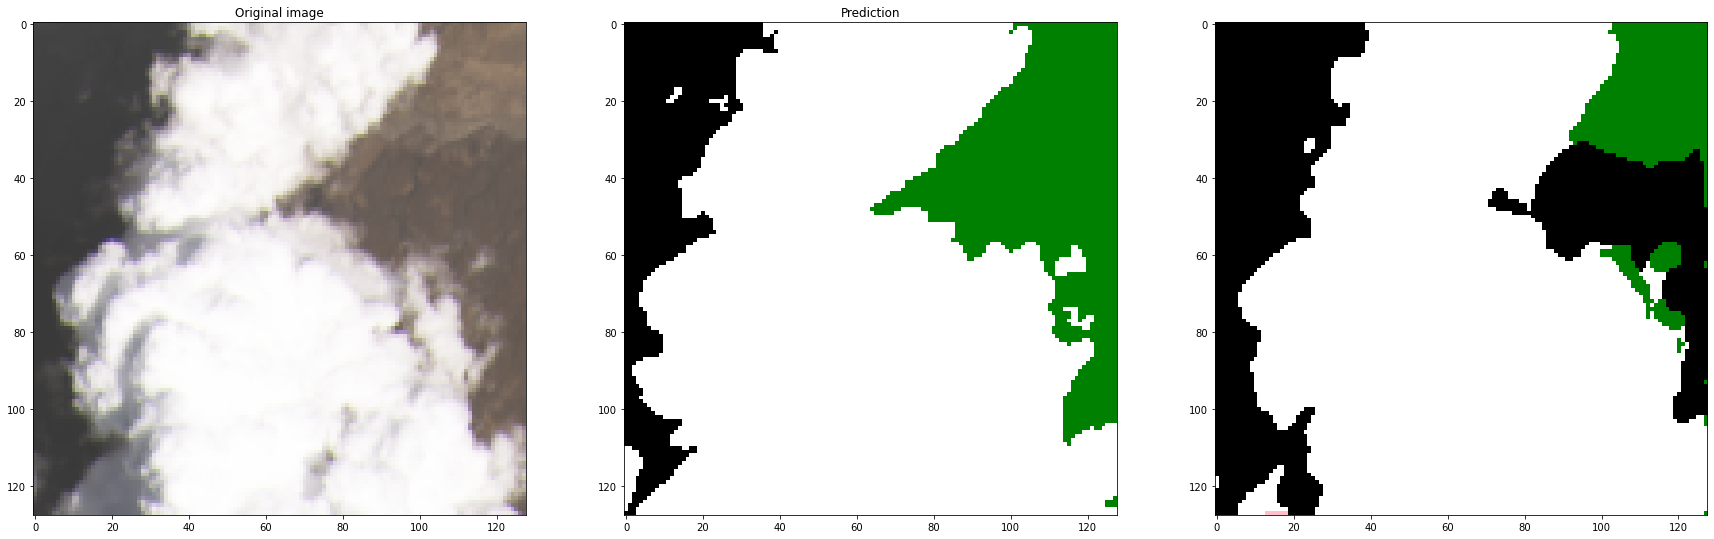

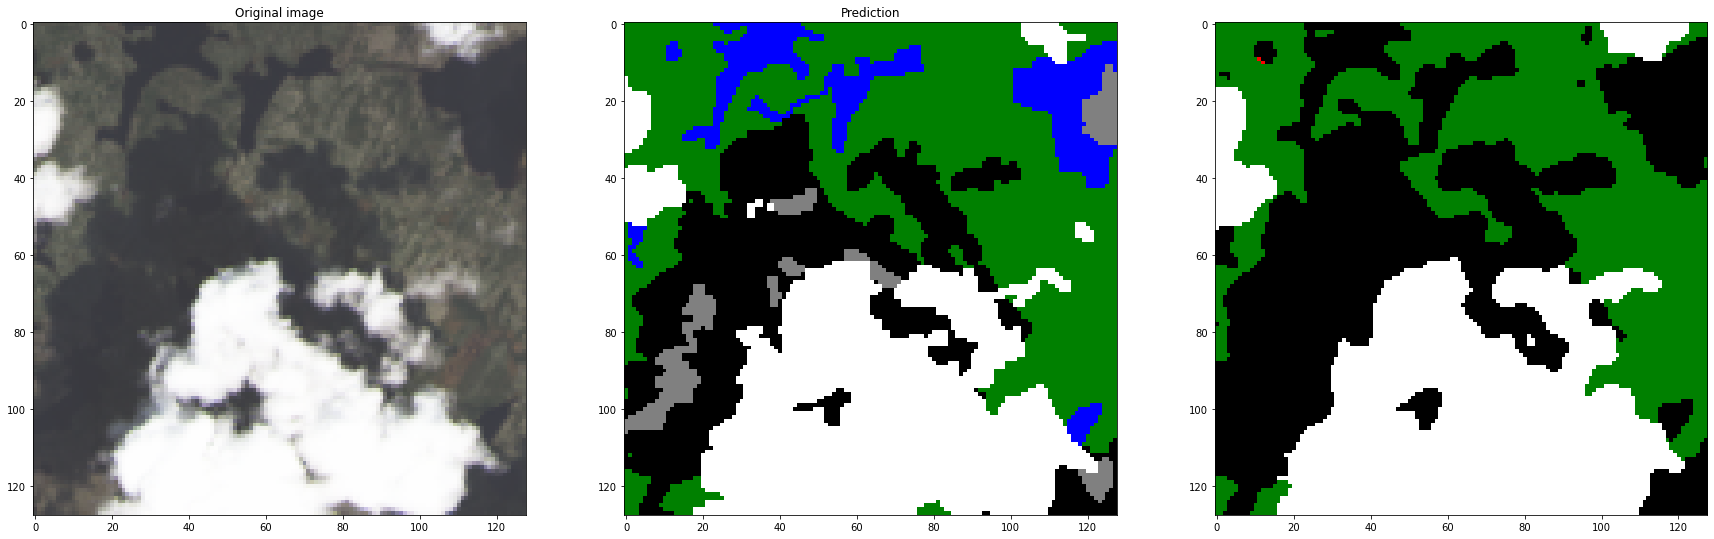

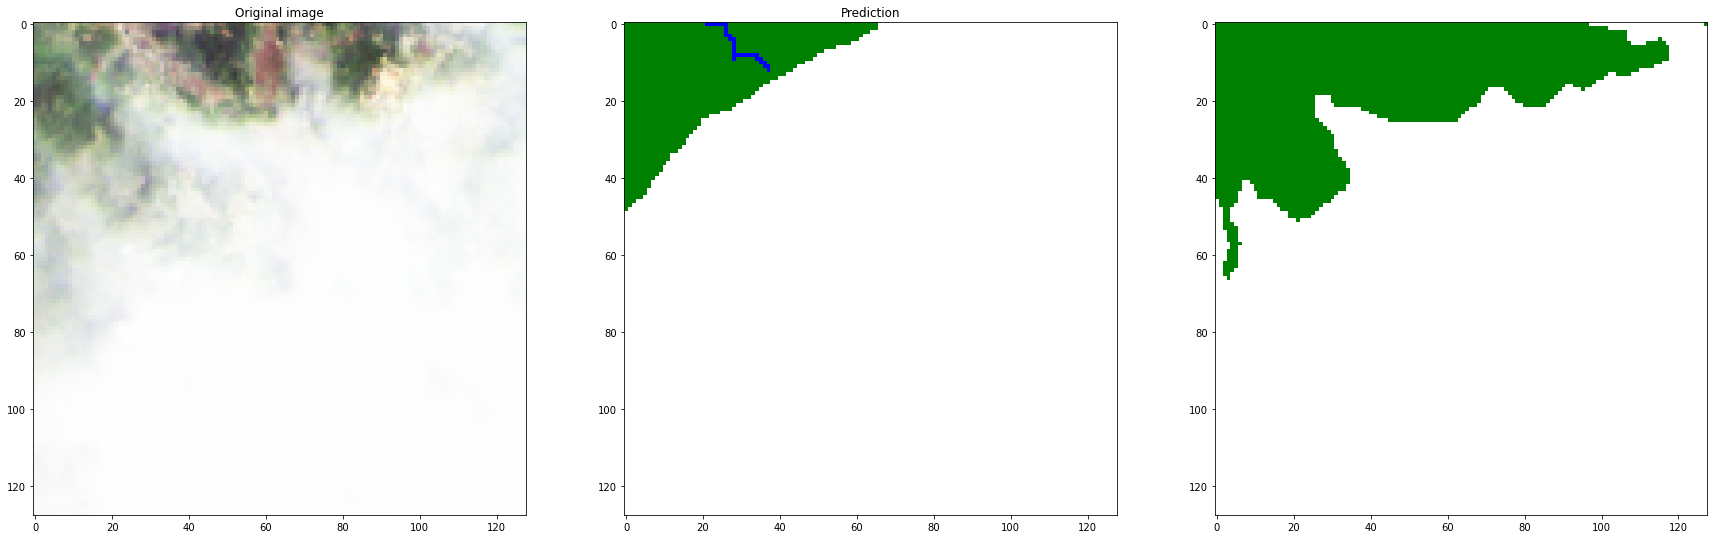

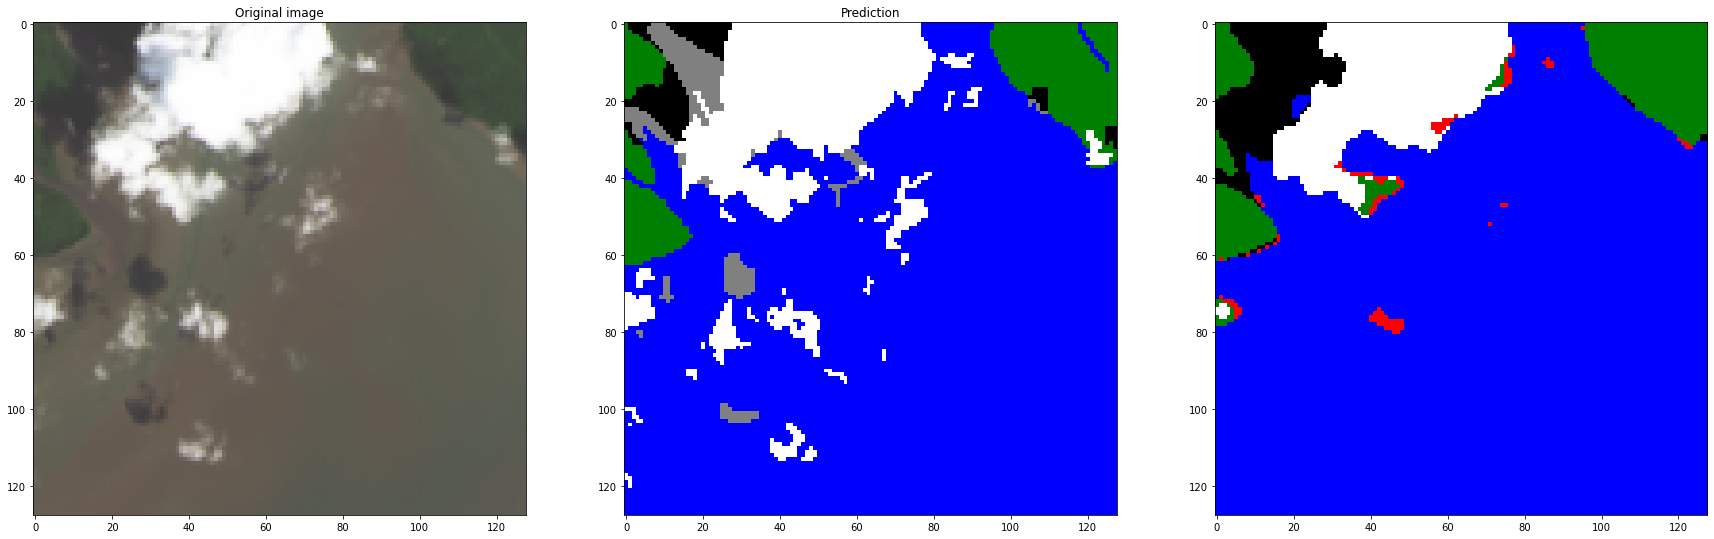

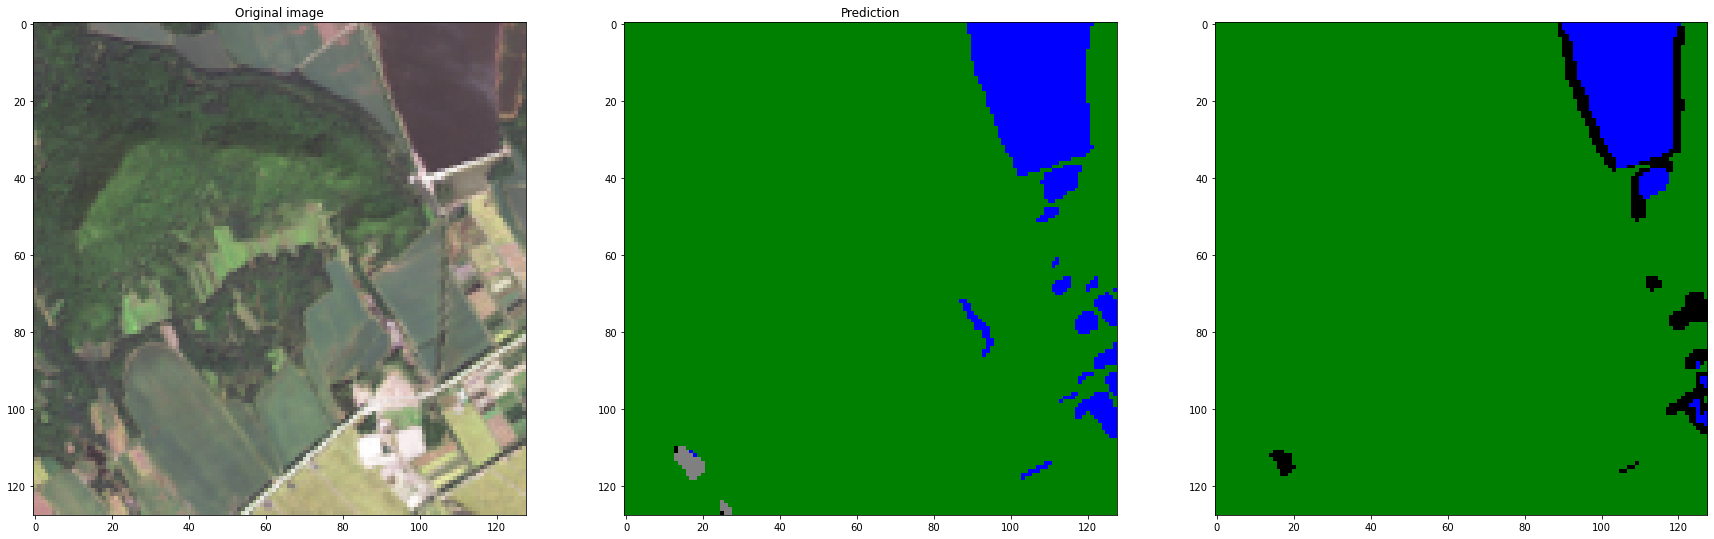

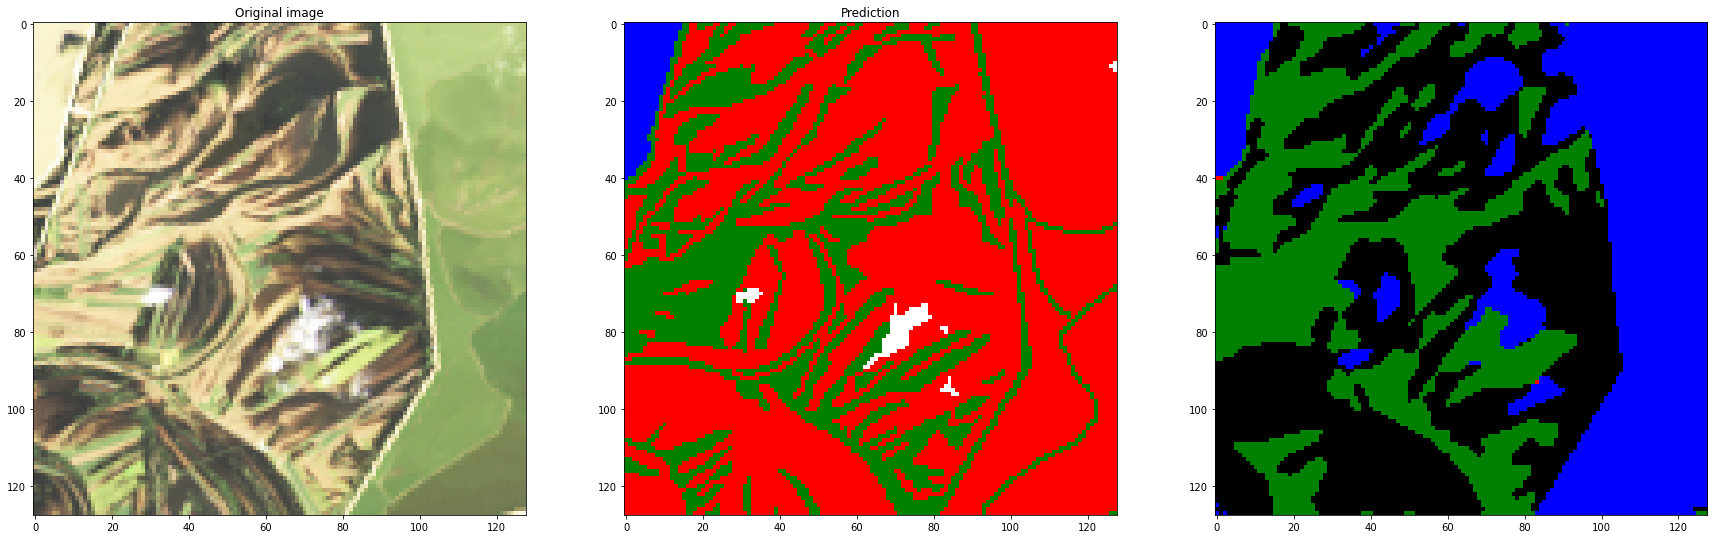

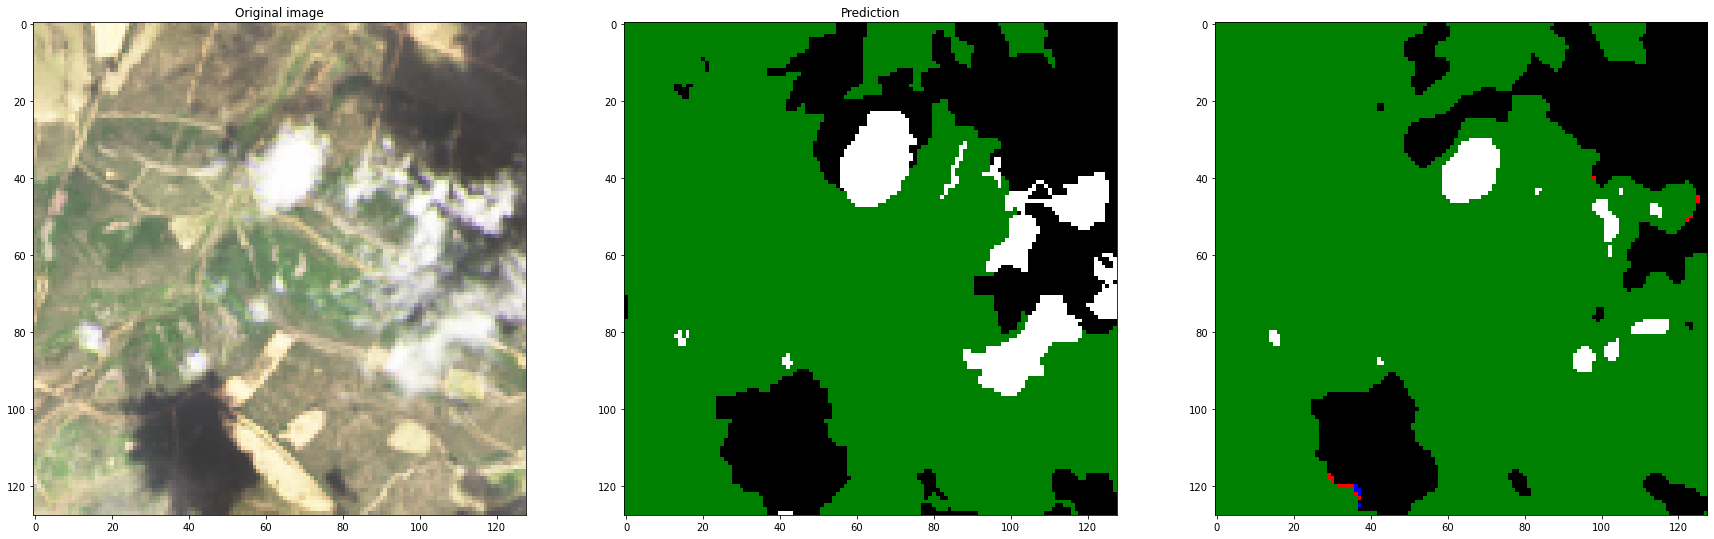

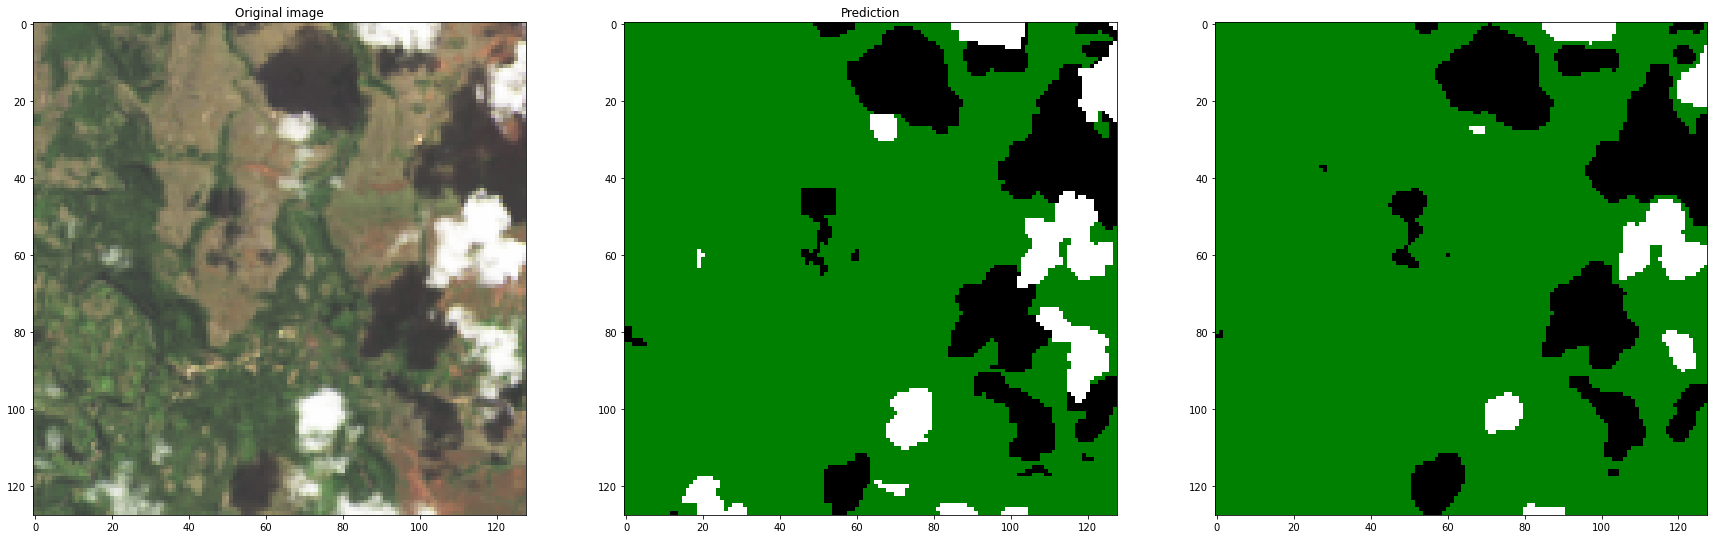

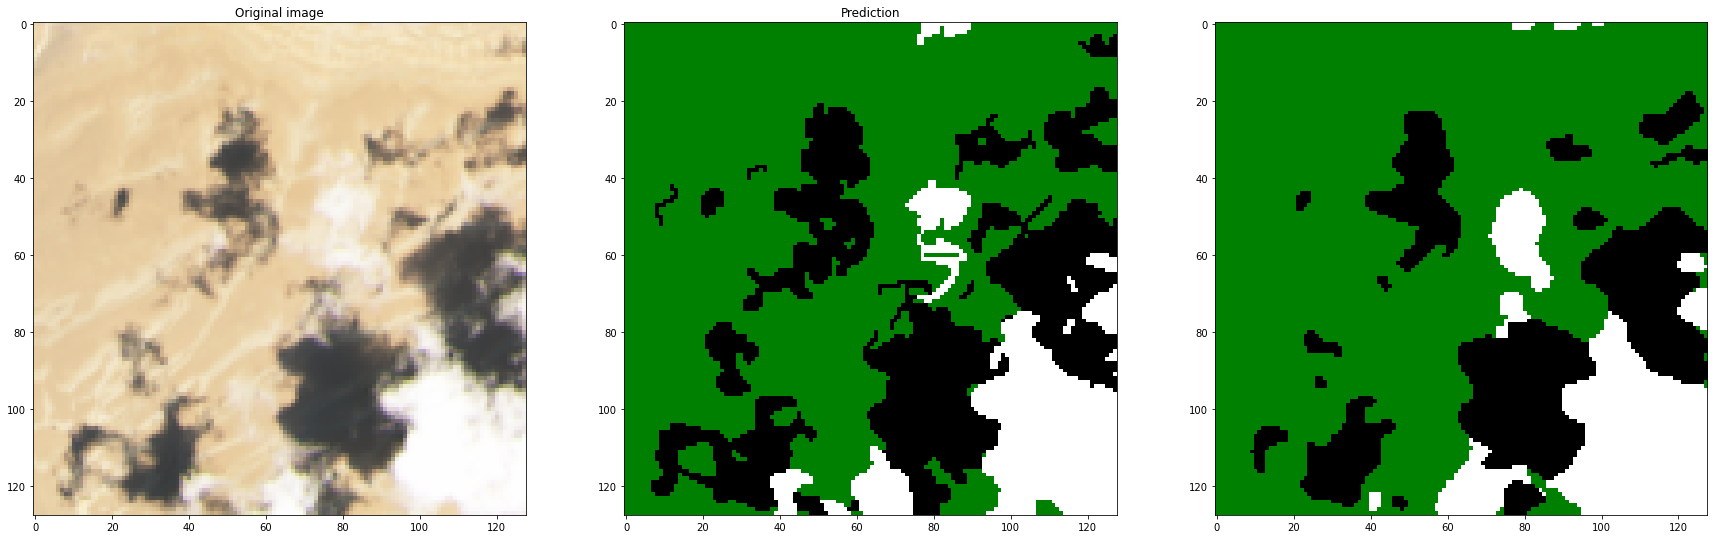

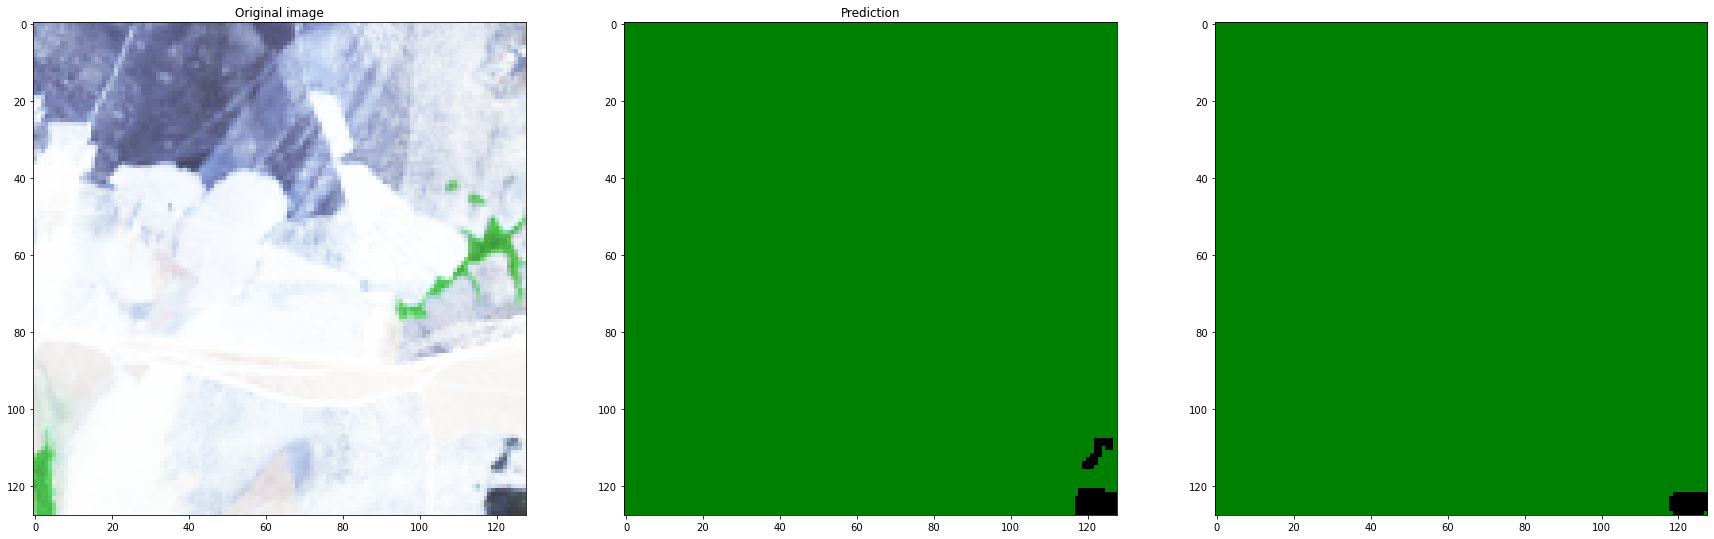

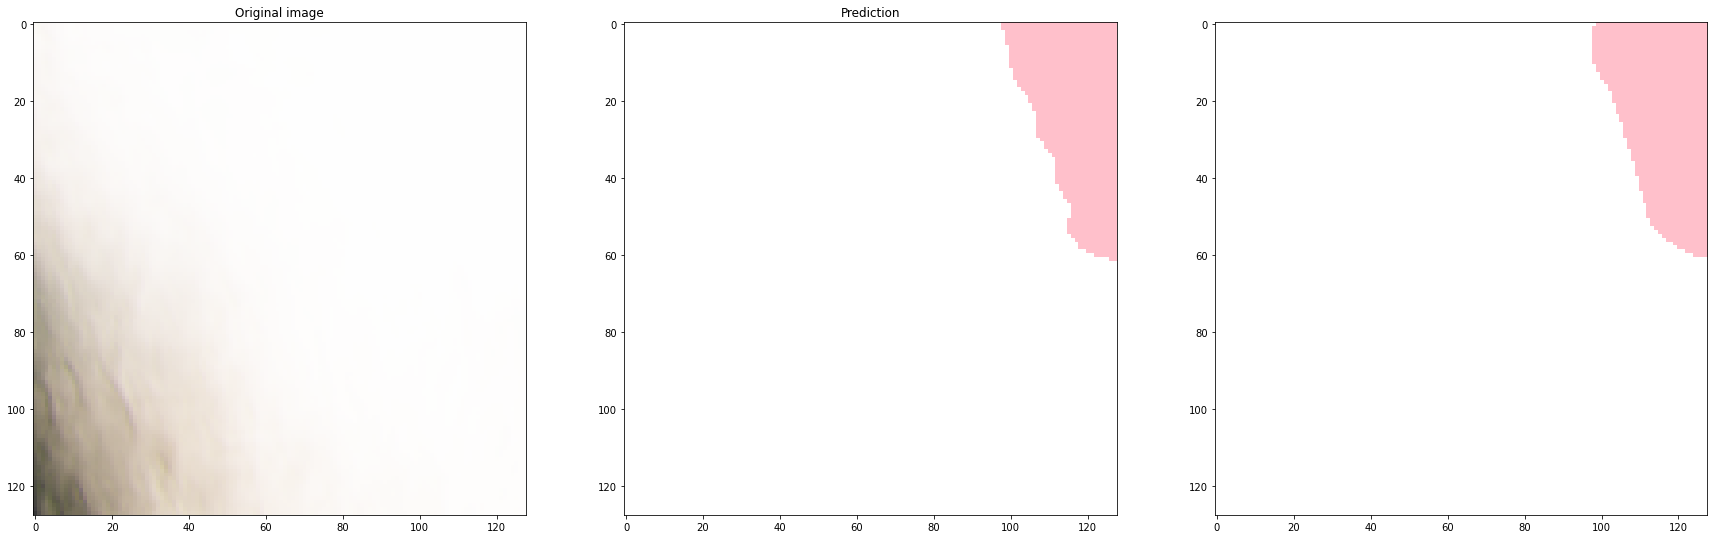

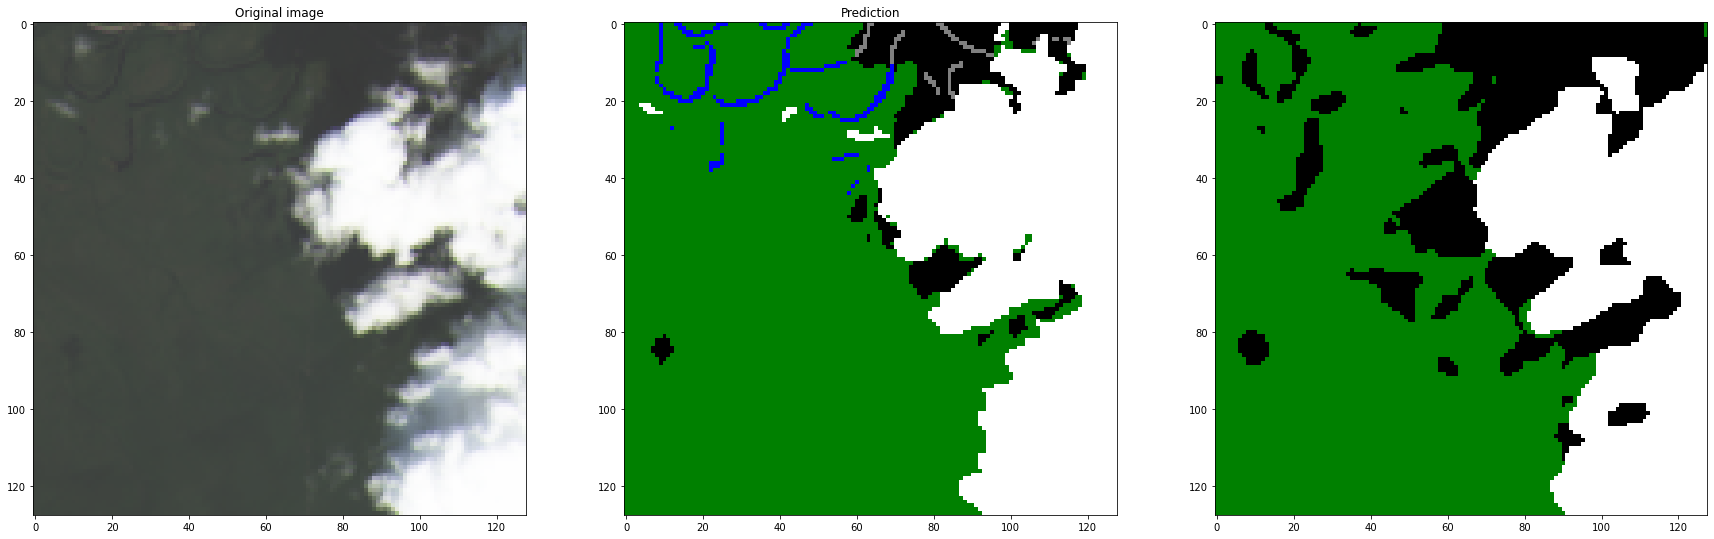

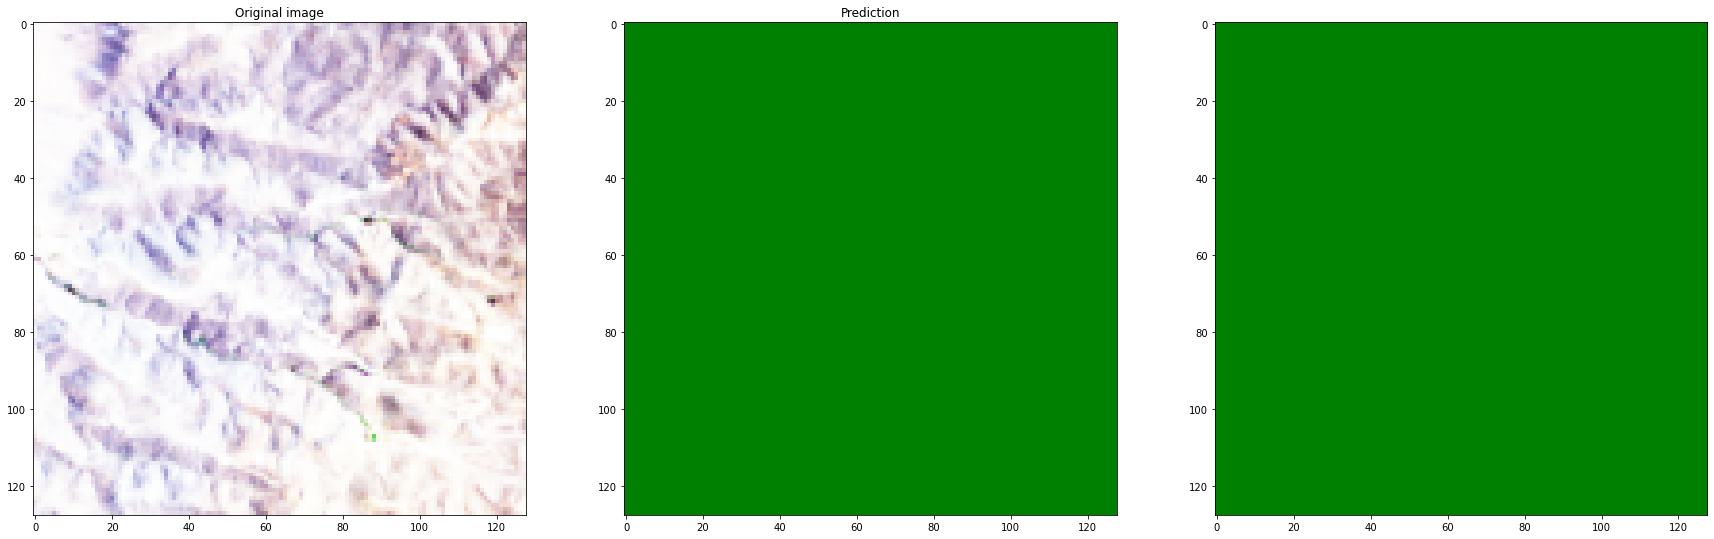

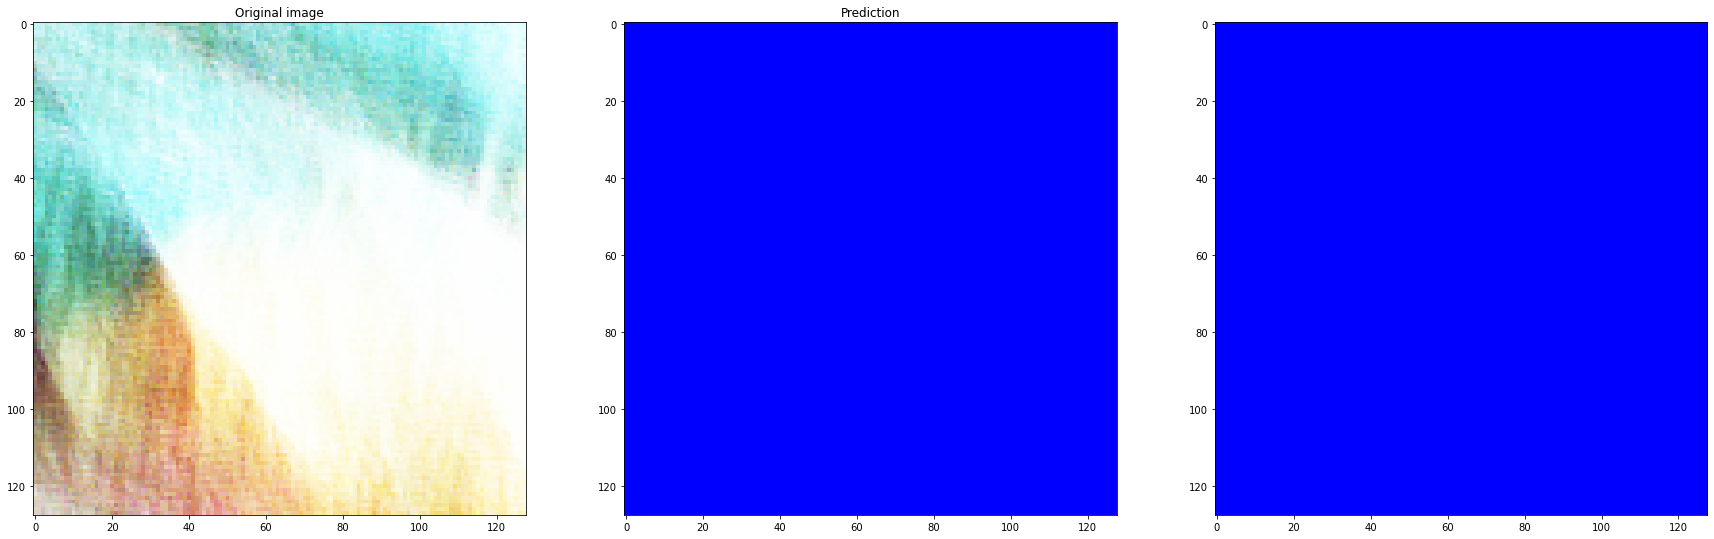

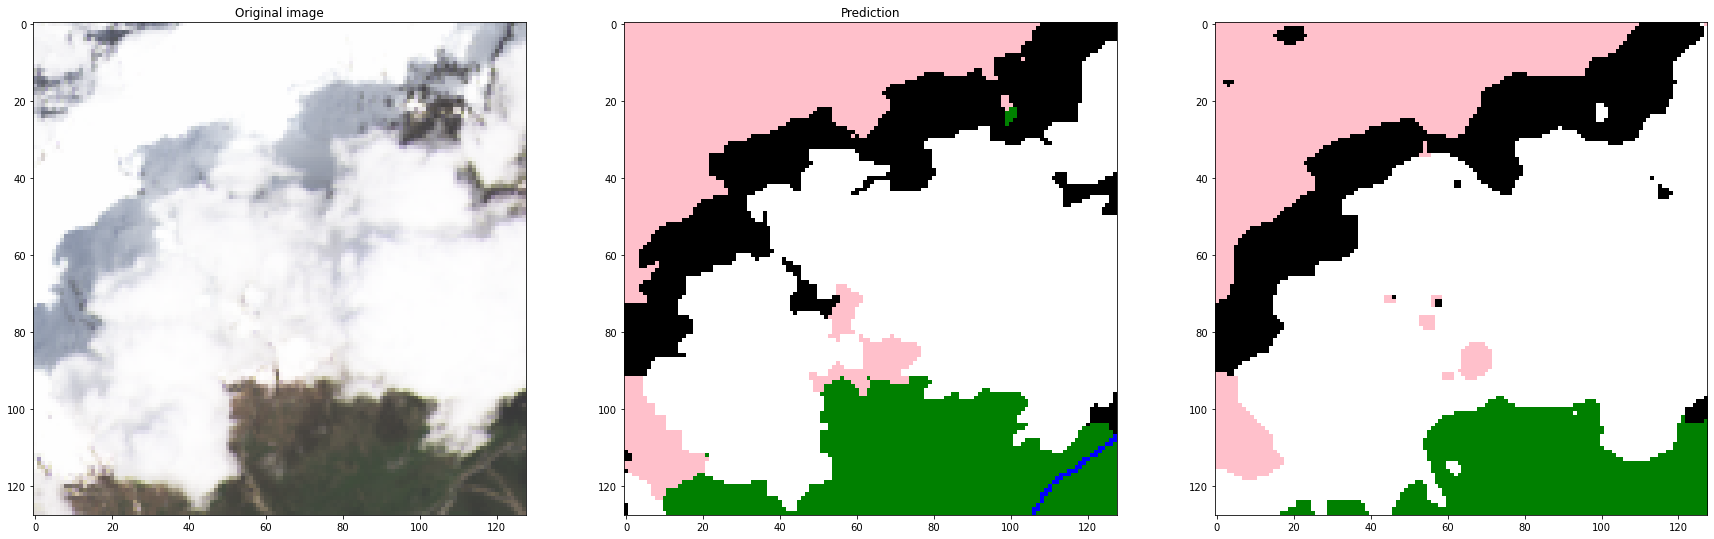

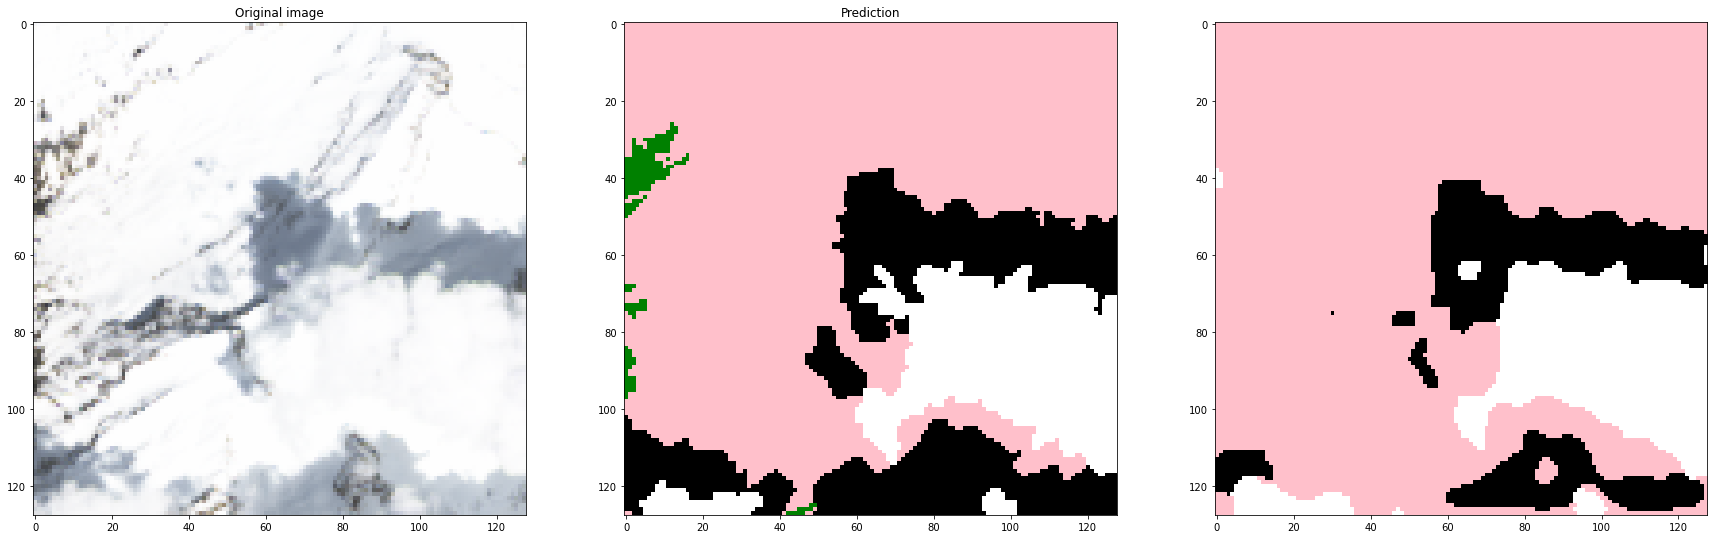

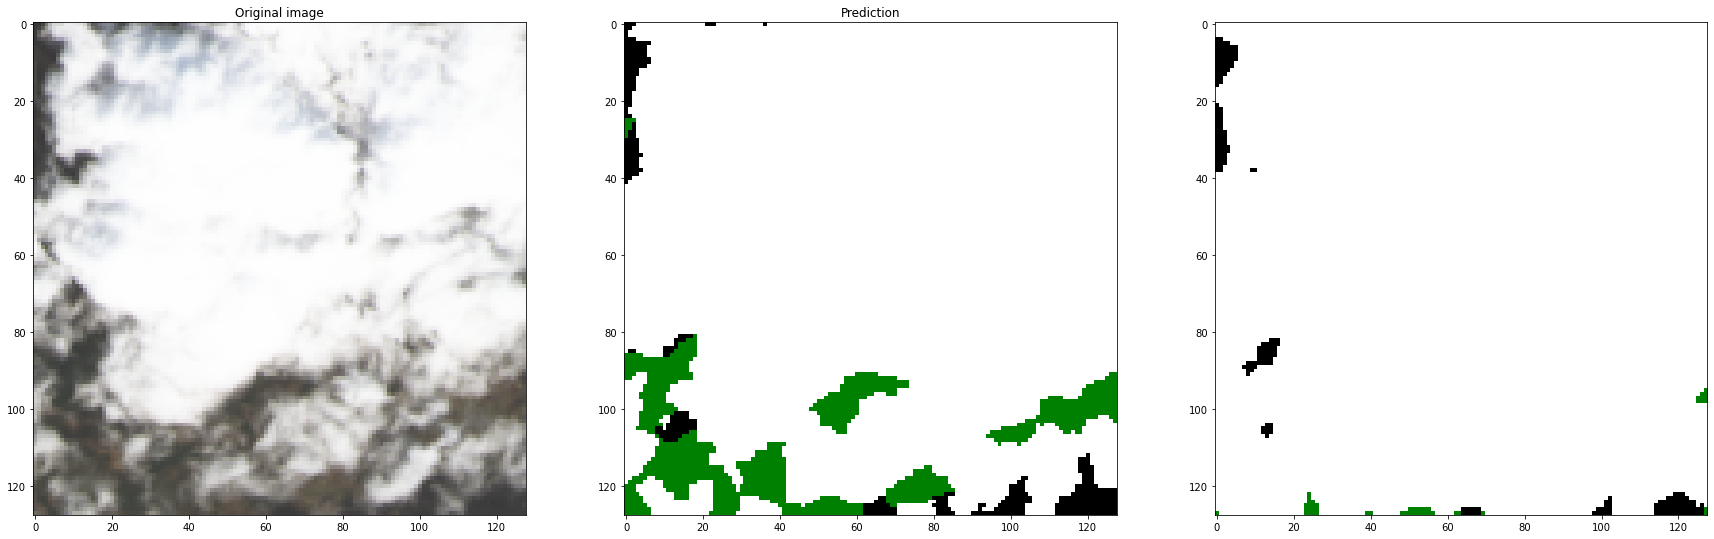

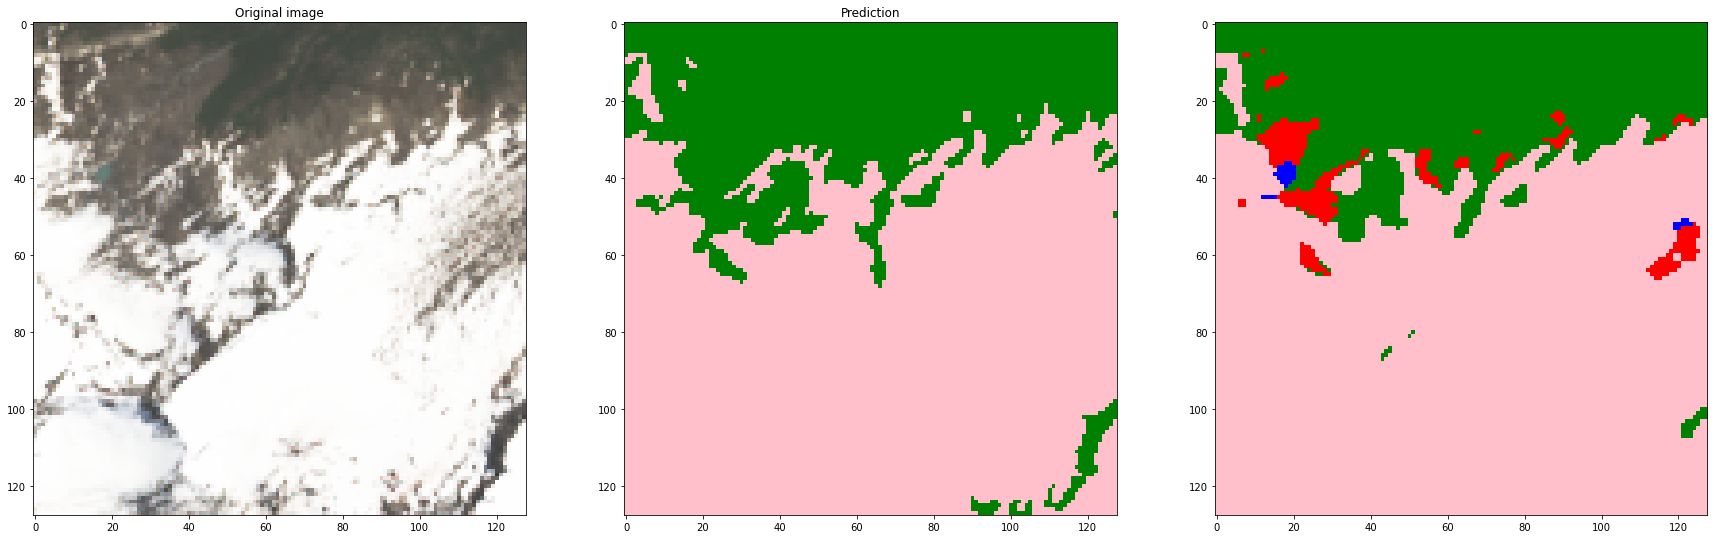

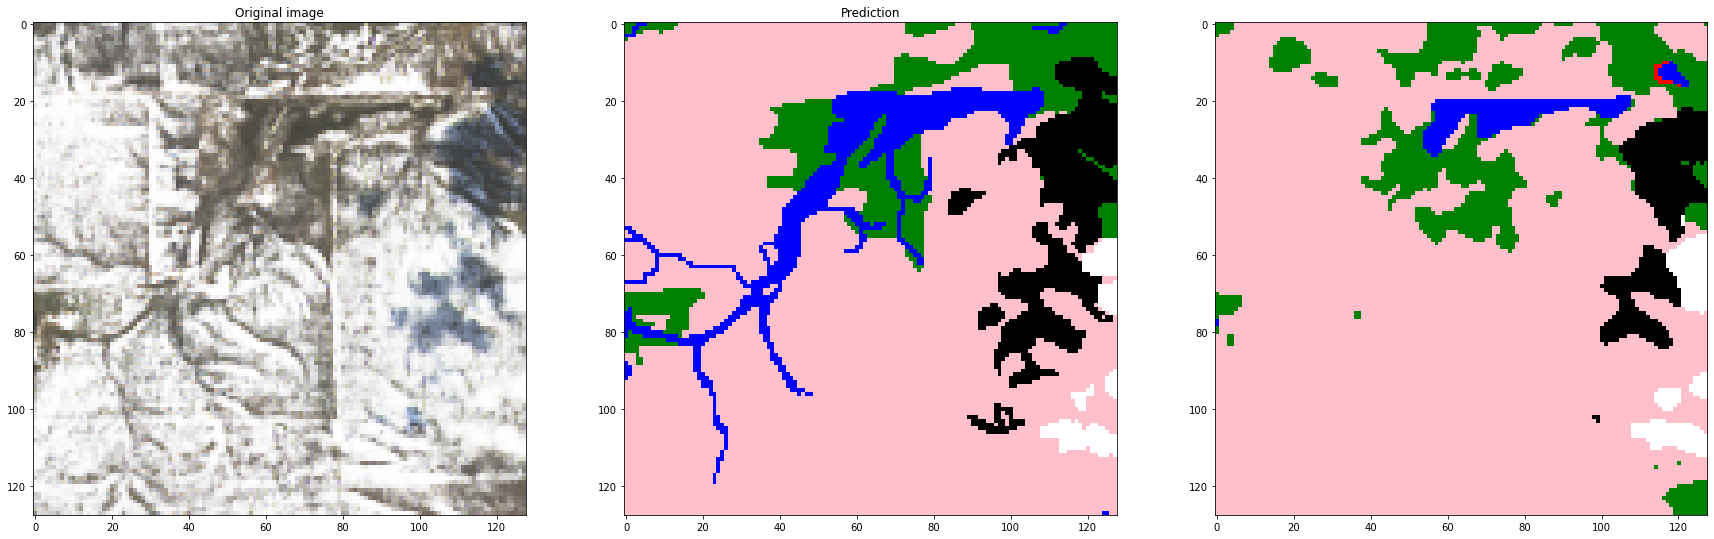

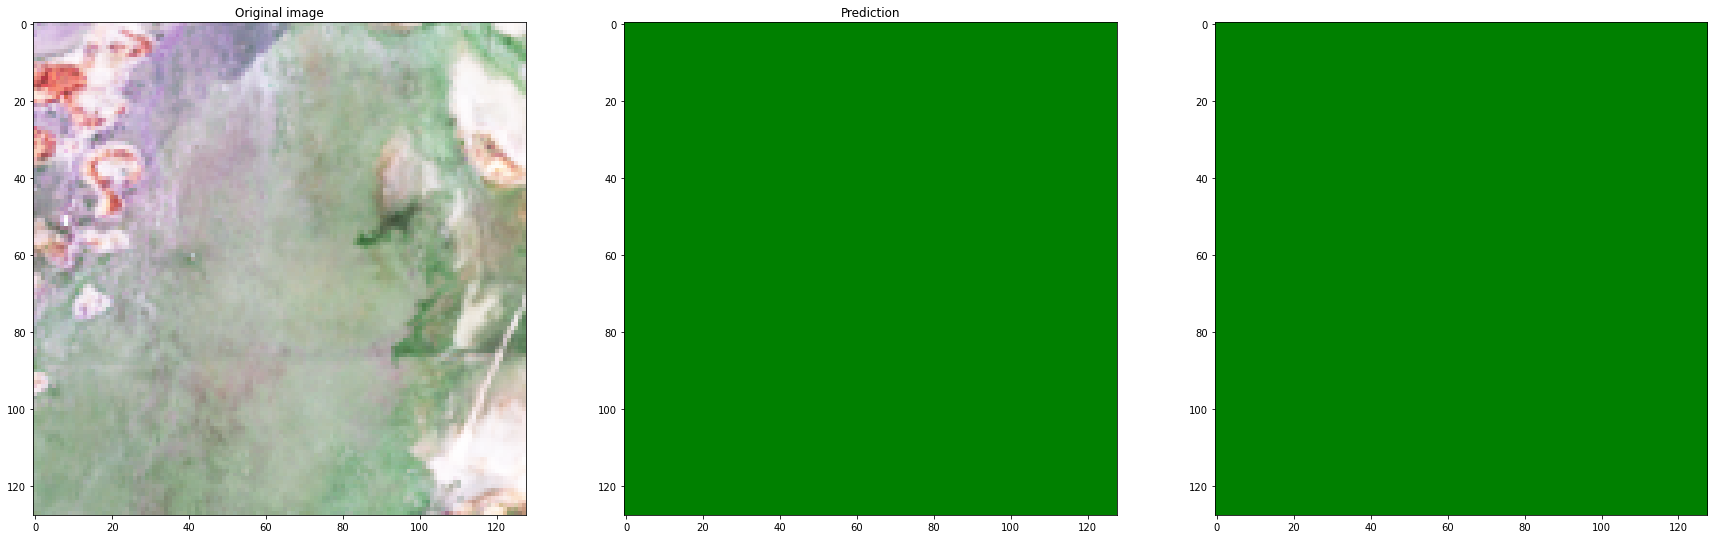

In [10]:
def get_prediction(prediction):
    mask = np.argmax(prediction, axis=-1)
    
    return mask

for idx in np.random.choice(range(len(y_test)-1), 20):

    color = get_l8_color(X_test[idx])
    mask = get_mask_array(y_test[idx])
    result = val_preds[idx]

    fig, ax = plt.subplots(1,3,figsize=(30,10))
    ax[0].imshow(color[:,:,0:3])
    ax[0].set_title('Original image')
    ax[1].imshow(mask,cmap=custom_cmap, norm=custom_norm)
    ax[1].set_title('Labels')
    ax[2].imshow(get_prediction(result), cmap=custom_cmap, norm=custom_norm)
    ax[1].set_title('Prediction')

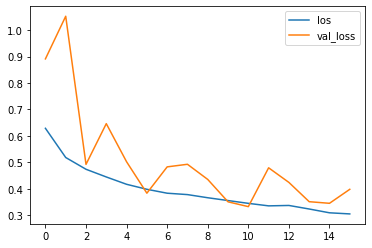

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

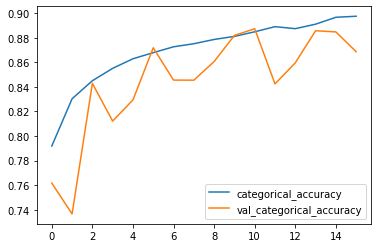